# Create the Crops to Train a Neural Network

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import rioxarray

import os
data_dir = os.path.abspath(os.path.join('..', 'data'))
output_dir = os.path.abspath(os.path.join('..', 'output'))

%matplotlib inline

import sys
import importlib
sys.path.append('../modules')
from reading import ascii_xyz
from plotting import raster_plotting
from processing import interpolate
importlib.reload(raster_plotting);

In [2]:
from matplotlib.colors import LinearSegmentedColormap
cmap_terrain = plt.get_cmap('terrain')

cmap_terrain_crust = LinearSegmentedColormap.from_list(
    'terrain_crust', cmap_terrain(np.linspace(0.25, 1, 256))
)
cmap_terrain_crust.set_bad(color='blue')

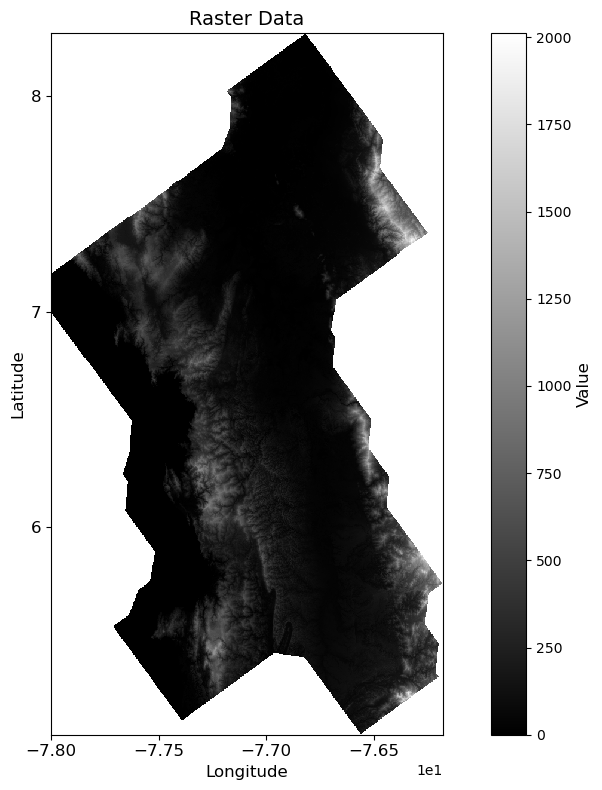

In [5]:
file_path = output_dir + '/raster/' +  r'\atrato_basin\pacifico_data_merged.tif'
data_stack = rioxarray.open_rasterio(file_path)

# region = (
#     -77.5, -77.0, 6.5, 6
# )
# data_stack = data_stack.sel(
#     x=slice(*region[:2]),
#     y=slice(*region[2:]),
# )
raster_plotting.plot_raster_data(data_stack.x, data_stack.y, data_stack[4], sampling=10)

## Crops by ratio

In [ ]:
import rasterio
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from math import floor

# Inputs
input_tiff = output_dir + '/raster/' +  r'\atrato_basin\pacifico_data_merged.tif'

base_paths = {
    'tiff_image': output_dir + '/raster/crops_stack/tiff/images',
    'tiff_gt': output_dir + '/raster/crops_stack/tiff/gt',
    'jpg_image': output_dir + '/raster/crops_stack/jpg/images',
    'jpg_gt': output_dir + '/raster/crops_stack/jpg/gt'
}

crop_size = 256
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2

# Crear subcarpetas
for key, path in base_paths.items():
    for subset in ['train','val','test']:
        os.makedirs(os.path.join(path, subset), exist_ok=True)

with rasterio.open(input_tiff) as src:
    data = src.read()  # [C,H,W]
    meta = src.meta.copy()
    height, width = src.height, src.width

    crops_list = []

    # Recorrer imagen en rejilla
    for row in range(0, height, crop_size):
        for col in range(0, width, crop_size):
            row_start = min(row, height - crop_size)
            col_start = min(col, width - crop_size)
            crop = data[:, row_start:row_start+crop_size, col_start:col_start+crop_size]

            # Filtrado de información
            image_channel = crop[4]  # Usar canal de imagen para el filtrado
            total_pixels = image_channel.size

            # Contar NaN/Inf
            nan_or_inf = np.isnan(image_channel) | np.isinf(image_channel)
            valid_pixels = total_pixels - np.sum(nan_or_inf)

            # Contar píxeles del valor más frecuente
            unique_vals, counts = np.unique(image_channel[~nan_or_inf], return_counts=True)
            max_count = counts.max() if counts.size > 0 else 0

            # Descarta si más del 50% son NaN/Inf o si un valor ocupa más del 50%
            if np.sum(nan_or_inf)/total_pixels > 0.5 or max_count/valid_pixels > 0.5:
                continue  # no agregar este crop

            if (np.isnan(crop).any() or np.isinf(crop).any() or
                np.any([np.unique(crop[c]).size == 1 for c in range(crop.shape[0])])):
                continue

            # Si pasa el filtro, lo añadimos
            crops_list.append((crop, row_start, col_start))


    print(f"Total crops válidos: {len(crops_list)}")

    # Asignar a train/val/test
    np.random.shuffle(crops_list)
    num_crops = len(crops_list)
    num_train = floor(train_ratio * num_crops)
    num_val   = floor(val_ratio * num_crops)
    num_test  = num_crops - num_train - num_val

    subsets = (
        ('train', crops_list[:num_train]),
        ('val', crops_list[num_train:num_train+num_val]),
        ('test', crops_list[num_train+num_val:])
    )

    crop_index = 0
    for subset_name, subset_crops in subsets:
        for crop, row_start, col_start in subset_crops:
            crop_index += 1

            # Actualizar transformaciones y metadatos
            transform = src.transform * rasterio.Affine.translation(col_start, row_start)
            meta_crop_img = meta.copy()
            meta_crop_img.update({
                "height": crop_size,
                "width": crop_size,
                "transform": transform,
                "count": crop.shape[0]-1  # canal 0 = label
            })
            meta_crop_l = meta.copy()
            meta_crop_l.update({
                "height": crop_size,
                "width": crop_size,
                "transform": transform,
                "count": 1
            })

            # Guardar TIFF
            tiff_image_path = os.path.join(base_paths['tiff_image'], subset_name, f"crop_{crop_index}.tif")
            tiff_gt_path = os.path.join(base_paths['tiff_gt'], subset_name, f"crop_{crop_index}.tif")
            with rasterio.open(tiff_image_path, 'w', **meta_crop_img) as dst:
                dst.write(crop[1:])  # canales de imagen
            with rasterio.open(tiff_gt_path, 'w', **meta_crop_l) as dst:
                dst.write(crop[0:1])  # canal de label

            # Guardar JPG
            jpg_image_path = os.path.join(base_paths['jpg_image'], subset_name, f"crop_{crop_index}.jpg")
            jpg_gt_path = os.path.join(base_paths['jpg_gt'], subset_name, f"crop_{crop_index}.jpg")
            plt.imsave(jpg_image_path, crop[4], cmap=cmap_terrain_crust)
            img = Image.fromarray((crop[0] * 255).astype(np.uint8))
            img.save(jpg_gt_path)

    print(f"Crops guardados: {crop_index}")


Total crops válidos: 167
Crops guardados: 167


In [ ]:
file_path = output_dir + r'\raster\crops_stack\tiff\images\train\crop_1.tif'
data = rioxarray.open_rasterio(file_path)
data;

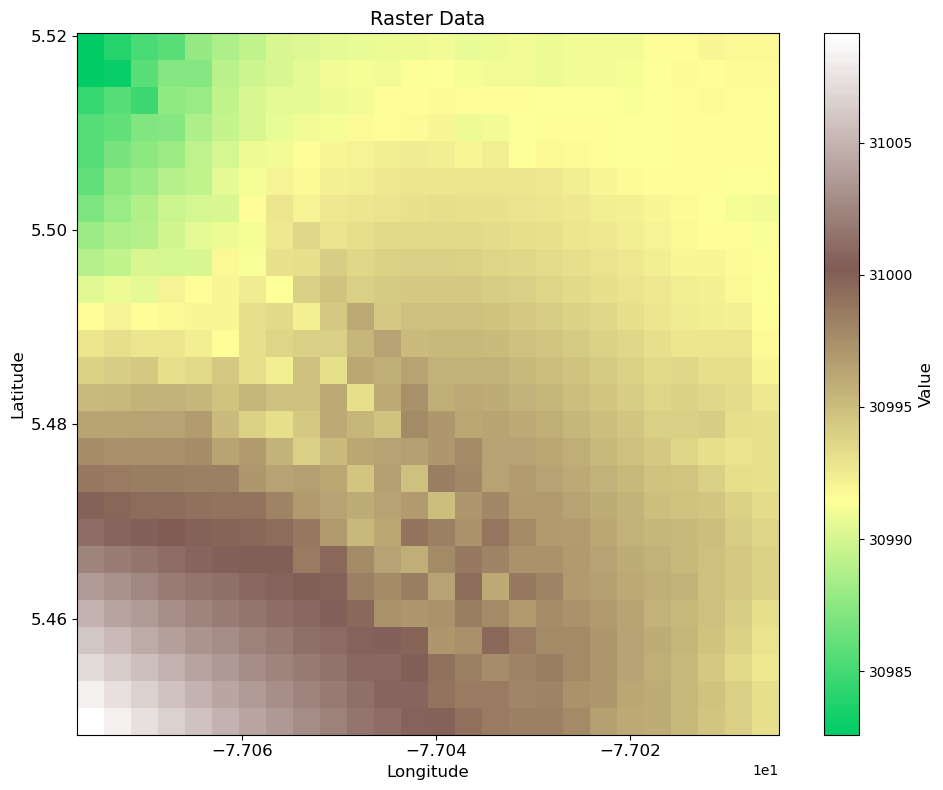

In [9]:
raster_plotting.plot_raster_data(data.x, data.y, data[2], sampling=10, cmap=cmap_terrain_crust)

## Crops by fix number

In [ ]:
import rasterio
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

# Inputs
input_tiff = output_dir + '/raster/' +  r'\atrato_basin\pacifico_data_merged.tif'

base_paths = {
    'tiff_image': output_dir + '/raster/crops_stack/tiff/images',
    'tiff_gt': output_dir + '/raster/crops_stack/tiff/gt',
    'jpg_image': output_dir + '/raster/crops_stack/jpg/images',
    'jpg_gt': output_dir + '/raster/crops_stack/jpg/gt'
}

crop_size = 256

# Crear subcarpetas
for key, path in base_paths.items():
    for subset in ['train','val','test']:
        os.makedirs(os.path.join(path, subset), exist_ok=True)

# Abrir TIFF principal
with rasterio.open(input_tiff) as src:
    data = src.read()  # [C,H,W]
    meta = src.meta.copy()
    height, width = src.height, src.width

    crops_list = []

    # Recorrer imagen en rejilla
    for row in range(0, height, crop_size):
        for col in range(0, width, crop_size):
            row_start = min(row, height - crop_size)
            col_start = min(col, width - crop_size)
            crop = data[:, row_start:row_start+crop_size, col_start:col_start+crop_size]

            # filtrado de información
            image_channel = crop[1]
            total_pixels = image_channel.size

            # Contar NaN/Inf
            nan_or_inf = np.isnan(image_channel) | np.isinf(image_channel)
            valid_pixels = total_pixels - np.sum(nan_or_inf)

            # Contar píxeles del valor más frecuente
            unique_vals, counts = np.unique(image_channel[~nan_or_inf], return_counts=True)
            max_count = counts.max() if counts.size > 0 else 0

            # Descarta si más del 50% son NaN/Inf o si un valor ocupa más del 50%
            if np.sum(nan_or_inf)/total_pixels > 0.5 or max_count/valid_pixels > 0.5:
                continue  # no agregar este crop

            if (np.isnan(crop).any() or np.isinf(crop).any() or
                np.any([np.unique(crop[c]).size == 1 for c in range(crop.shape[0])])):
                continue

            # Si pasa el filtro, lo añadimos
            crops_list.append((crop, row_start, col_start))

    print(f"Total crops válidos: {len(crops_list)}")

    # Tomar un número fijo de crops
    np.random.shuffle(crops_list)
    num_train = 20
    num_val = 10
    num_test = 10

    subsets = (
        ('train', crops_list[:num_train]),
        ('val', crops_list[num_train:num_train+num_val]),
        ('test', crops_list[num_train+num_val:num_train+num_val+num_test])
    )

    crop_index = 0
    for subset_name, subset_crops in subsets:
        for crop, row_start, col_start in subset_crops:
            crop_index += 1

            # Transformaciones y metadatos
            transform = src.transform * rasterio.Affine.translation(col_start, row_start)
            meta_crop_img = meta.copy()
            meta_crop_img.update({
                "height": crop_size,
                "width": crop_size,
                "transform": transform,
                "count": crop.shape[0]-1  # canal 0 = label
            })
            meta_crop_l = meta.copy()
            meta_crop_l.update({
                "height": crop_size,
                "width": crop_size,
                "transform": transform,
                "count": 1
            })

            # Guardar TIFF
            tiff_image_path = os.path.join(base_paths['tiff_image'], subset_name, f"crop_{crop_index}.tif")
            tiff_gt_path = os.path.join(base_paths['tiff_gt'], subset_name, f"crop_{crop_index}.tif")
            with rasterio.open(tiff_image_path, 'w', **meta_crop_img) as dst:
                dst.write(crop[1:])  # canales de imagen
            with rasterio.open(tiff_gt_path, 'w', **meta_crop_l) as dst:
                dst.write(crop[0:1])  # canal de label

            # Guardar JPG
            jpg_image_path = os.path.join(base_paths['jpg_image'], subset_name, f"crop_{crop_index}.jpg")
            jpg_gt_path = os.path.join(base_paths['jpg_gt'], subset_name, f"crop_{crop_index}.jpg")
            plt.imsave(jpg_image_path, crop[1], cmap='gray', vmin=0, vmax=150)
            img = Image.fromarray((crop[0] * 255).astype(np.uint8))
            img.save(jpg_gt_path)

    print(f"Crops guardados: {crop_index}")
